In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Dataset Description

| **Variable** | **Description** |
|--------------|-----------------|
| `age`        | Age of the patient in years |
| `sex`        | Gender of the patient (0 = male, 1 = female) |
| `cp`         | Chest pain type: <br> 0: Typical angina <br> 1: Atypical angina <br> 2: Non-anginal pain <br> 3: Asymptomatic |
| `trestbps`   | Resting blood pressure in mm Hg |
| `chol`       | Serum cholesterol in mg/dl |
| `fbs`        | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false) |
| `restecg`    | Resting electrocardiographic results: <br> 0: Normal <br> 1: ST-T wave abnormality <br> 2: Left ventricular hypertrophy |
| `thalach`    | Maximum heart rate achieved during stress test |
| `exang`      | Exercise-induced angina (1 = yes, 0 = no) |
| `oldpeak`    | ST depression induced by exercise relative to rest |
| `slope`      | Slope of peak exercise ST segment: <br> 0: Upsloping <br> 1: Flat <br> 2: Downsloping |
| `ca`         | Number of major vessels (0–4) colored by fluoroscopy |
| `thal`       | Thalium stress test result: <br> 0: Normal <br> 1: Fixed defect <br> 2: Reversible defect <br> 3: Not described |
| `target`     | Heart disease status (0 = no disease, 1 = presence of disease) |


In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
##continuous features
continuous_features = ['age','trestbps','chol','thalach','oldpeak']
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert] = df[features_to_convert].astype('object')
df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [7]:
df.describe().T

count        mean        std    min    25%    50%    75%    max
age       303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
trestbps  303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
chol      303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
thalach   303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
oldpeak   303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2

In [8]:
df.describe(include='object')

sex   cp  fbs  restecg  exang  slope   ca  thal  target
count   303  303  303      303    303    303  303   303     303
unique    2    4    2        3      2      3    5     4       2
top       1    0    0        1      0      2    0     2       1
freq    207  143  258      152    204    142  175   166     165

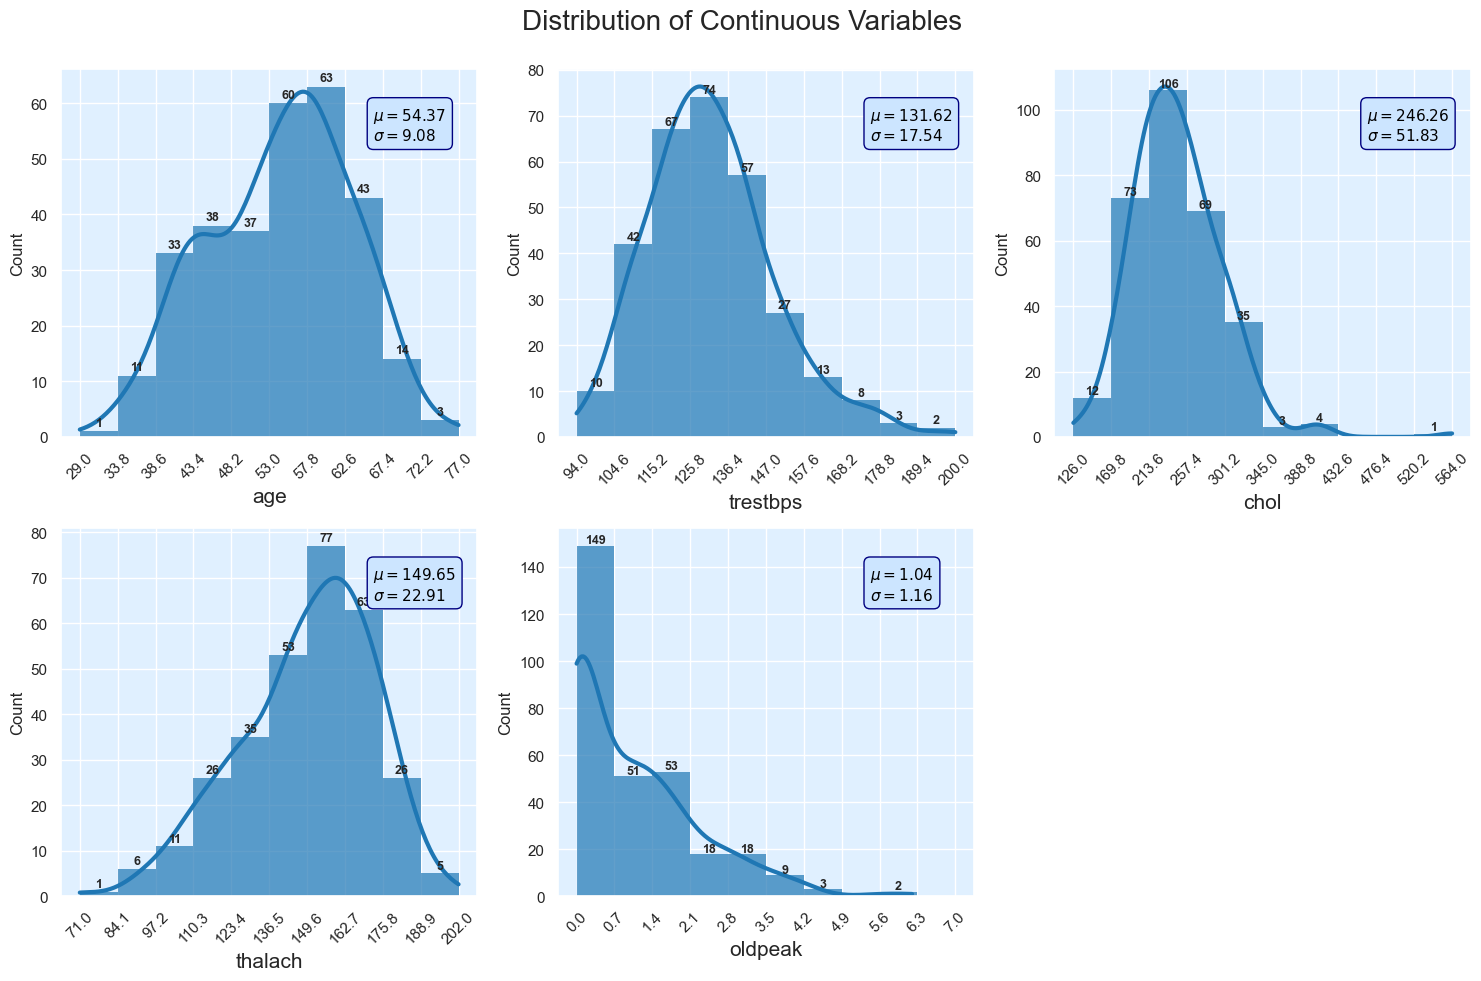

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set new background color and grid style
sns.set(style='darkgrid', rc={'axes.facecolor': '#e0f0ff'})
sns.set_palette(sns.color_palette(["#1f77b4"]))  # Blue tone

df_continuous = df[continuous_features]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(
        df_continuous[col],
        range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max()))
    )

    graph = sns.histplot(
        data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
        edgecolor='none', color='#1f77b4', alpha=0.7, line_kws={'lw': 3}
    )

    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].tick_params(axis='x', rotation=45)
    ax[x, y].grid(color='white')

    for p in graph.patches:
        height = int(p.get_height())
        if height > 0:
            ax[x, y].annotate(str(height), (p.get_x() + p.get_width() / 2, height + 1),
                              ha='center', fontsize=9, fontweight="bold")

    textstr = '\n'.join((
        rf'$\mu={df_continuous[col].mean():.2f}$',
        rf'$\sigma={df_continuous[col].std():.2f}$'
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes,
                  fontsize=11, verticalalignment='top', color='black',
                  bbox=dict(boxstyle='round', facecolor='#cce5ff', edgecolor='navy', pad=0.4))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [10]:
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=2, cols=3, subplot_titles=continuous_features)

for i, col in enumerate(continuous_features):
    row = i // 3 + 1
    col_num = i % 3 + 1
    fig.add_trace(
        go.Histogram(
            x=df[col], name=col,
            marker_color='dodgerblue',
            opacity=0.75,
            hovertemplate='%{x}<br>Count: %{y}<extra></extra>'
        ),
        row=row, col=col_num
    )

fig.update_layout(
    height=700, width=1100,
    title_text="📊 Interactive Distribution of Continuous Features",
    showlegend=False, template='plotly_white'
)
fig.show()


In [11]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

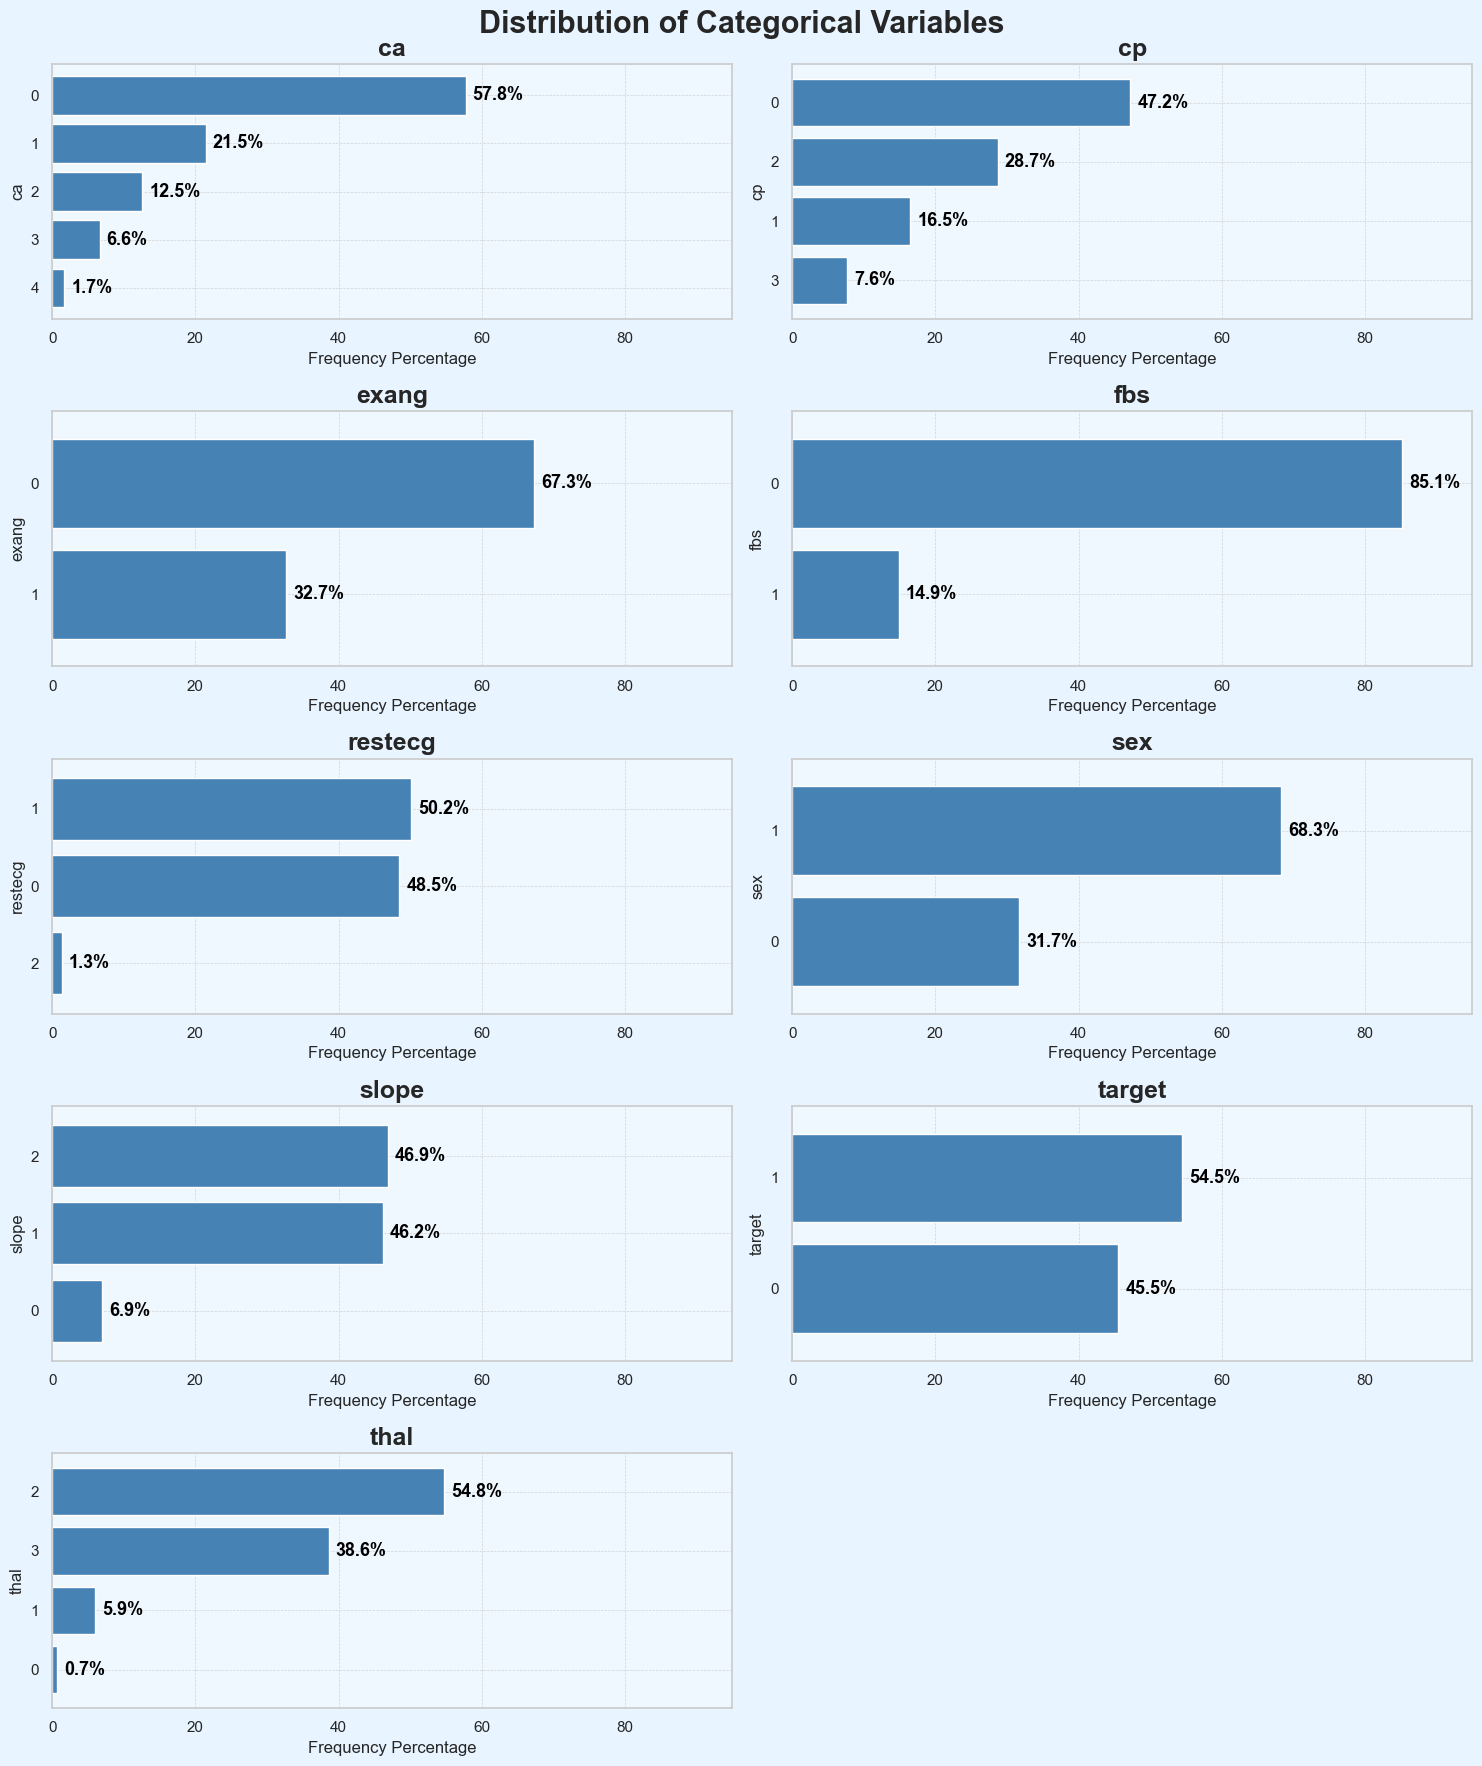

In [12]:
sns.set(style='whitegrid')  # Light background with grid lines

# Set up the subplot for a 5x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
fig.patch.set_facecolor('#e8f4ff')  # Light blue background

for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot horizontal bar chart in blue
    value_counts.plot(
        kind='barh', ax=ax[row, col_idx],
        width=0.8, color='steelblue'
    )
    
    # Annotate bars with percentage values
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value + 1, index, f'{value:.1f}%', 
                              fontsize=13, fontweight='bold', va='center', color='black')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=18, fontweight='bold')
    ax[row, col_idx].grid(True, linestyle='--', linewidth=0.5, color='lightgray')
    ax[row, col_idx].set_facecolor('#f0f8ff')  # Very light blue inside each subplot

# Hide empty subplot
ax[4, 1].axis('off')

# Main title and layout
plt.suptitle('Distribution of Categorical Variables', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


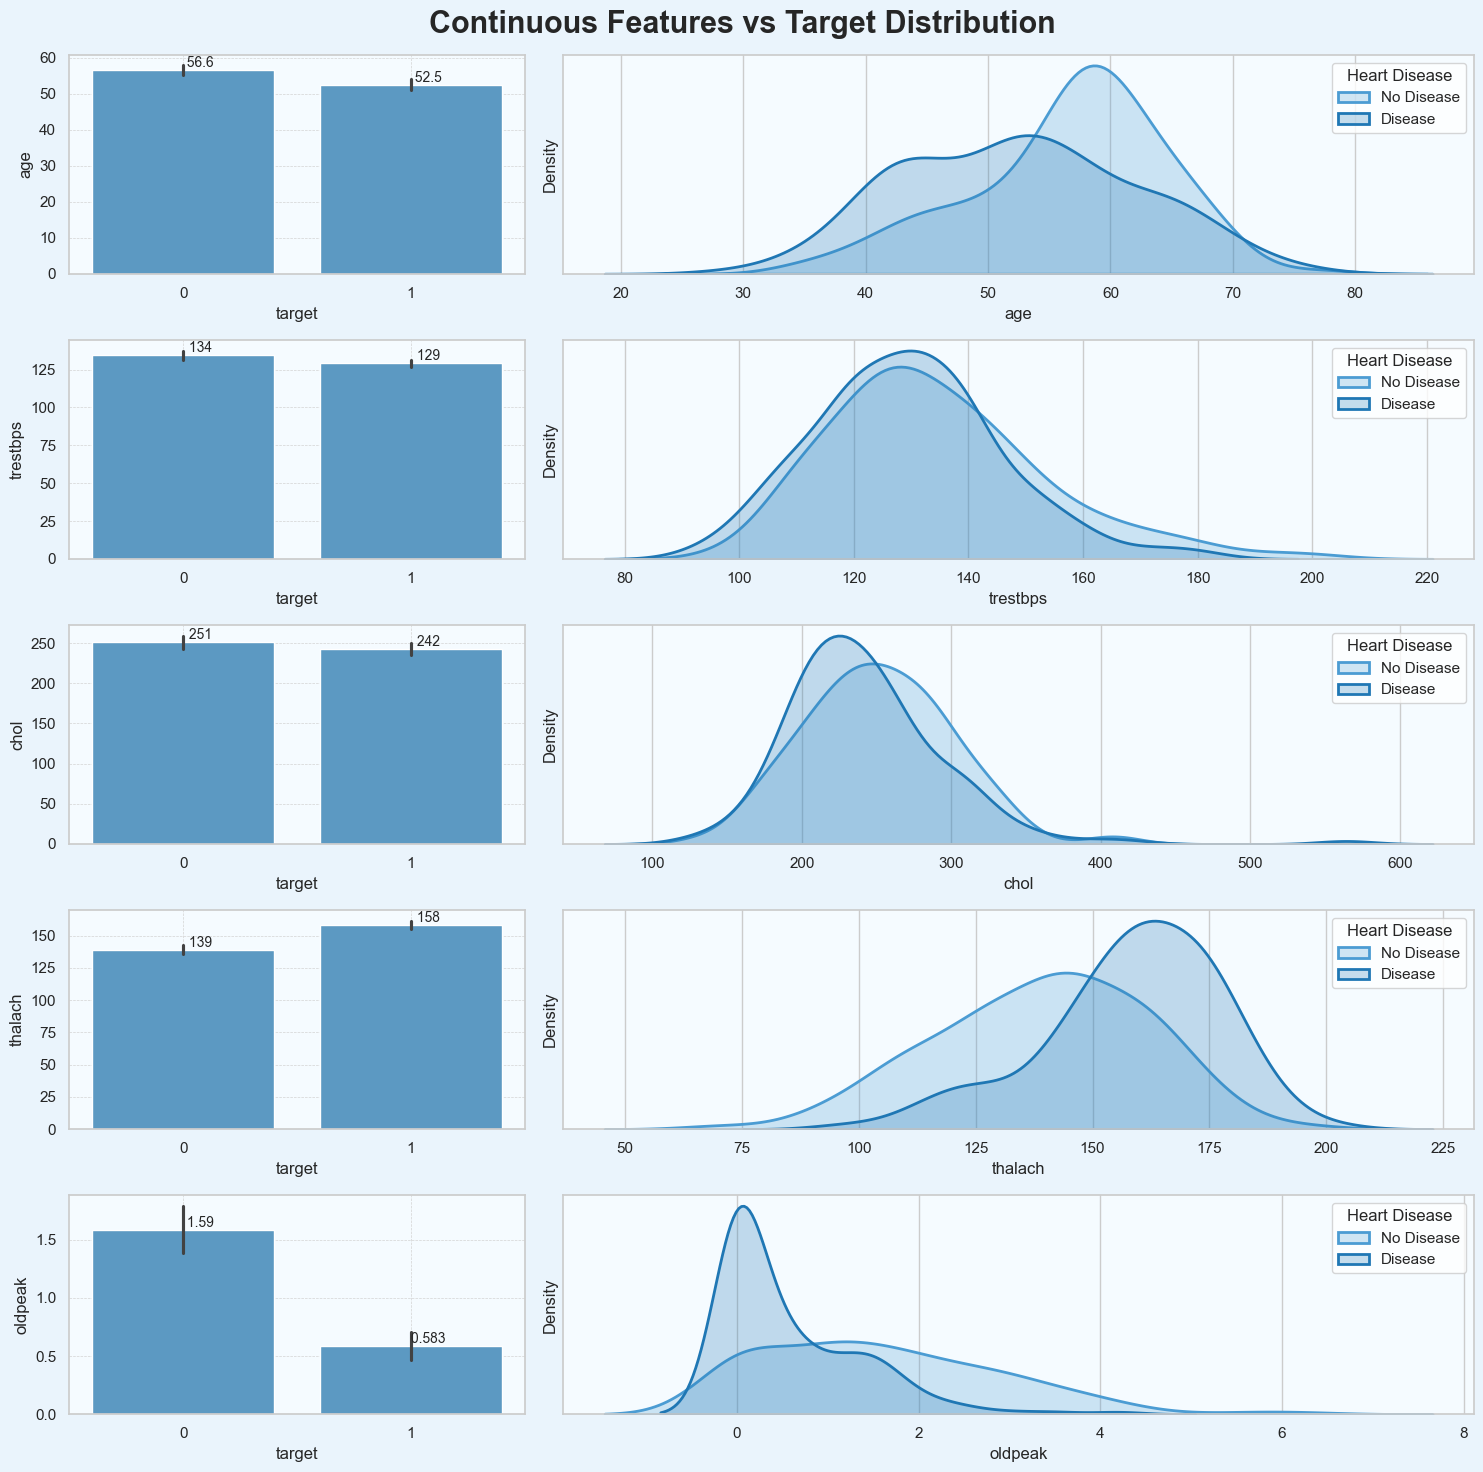

In [13]:
# Set color palette and background style
sns.set(style='whitegrid', palette=['#4b9cd3', '#1f77b4'])  # Light to medium blues

# Create the subplots with background styling
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15, 15), 
                       gridspec_kw={'width_ratios': [1, 2]})
fig.patch.set_facecolor('#eaf4fc')  # Light blue canvas background

# Loop to generate barplots and KDE plots
for i, col in enumerate(continuous_features):
    # Barplot: mean per target group
    bar = sns.barplot(data=df, x="target", y=col, ax=ax[i, 0])

    # KDE Plot: distribution for each target class
    sns.kdeplot(data=df[df["target"] == 0], x=col, fill=True, linewidth=2,
                ax=ax[i, 1], label='No Disease', color='#4b9cd3')
    sns.kdeplot(data=df[df["target"] == 1], x=col, fill=True, linewidth=2,
                ax=ax[i, 1], label='Disease', color='#1f77b4')
    
    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title='Heart Disease', loc='upper right')
    ax[i, 1].set_facecolor('#f5fbff')  # Gentle panel background

    # Add value labels to barplot
    for cont in bar.containers:
        bar.bar_label(cont, fmt='         %.3g', fontsize=10)

    # Style barplot axes
    ax[i, 0].grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
    ax[i, 0].set_facecolor('#f5fbff')  # Match KDE panel background

# Layout and title
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [14]:
# Remove 'target' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'target']

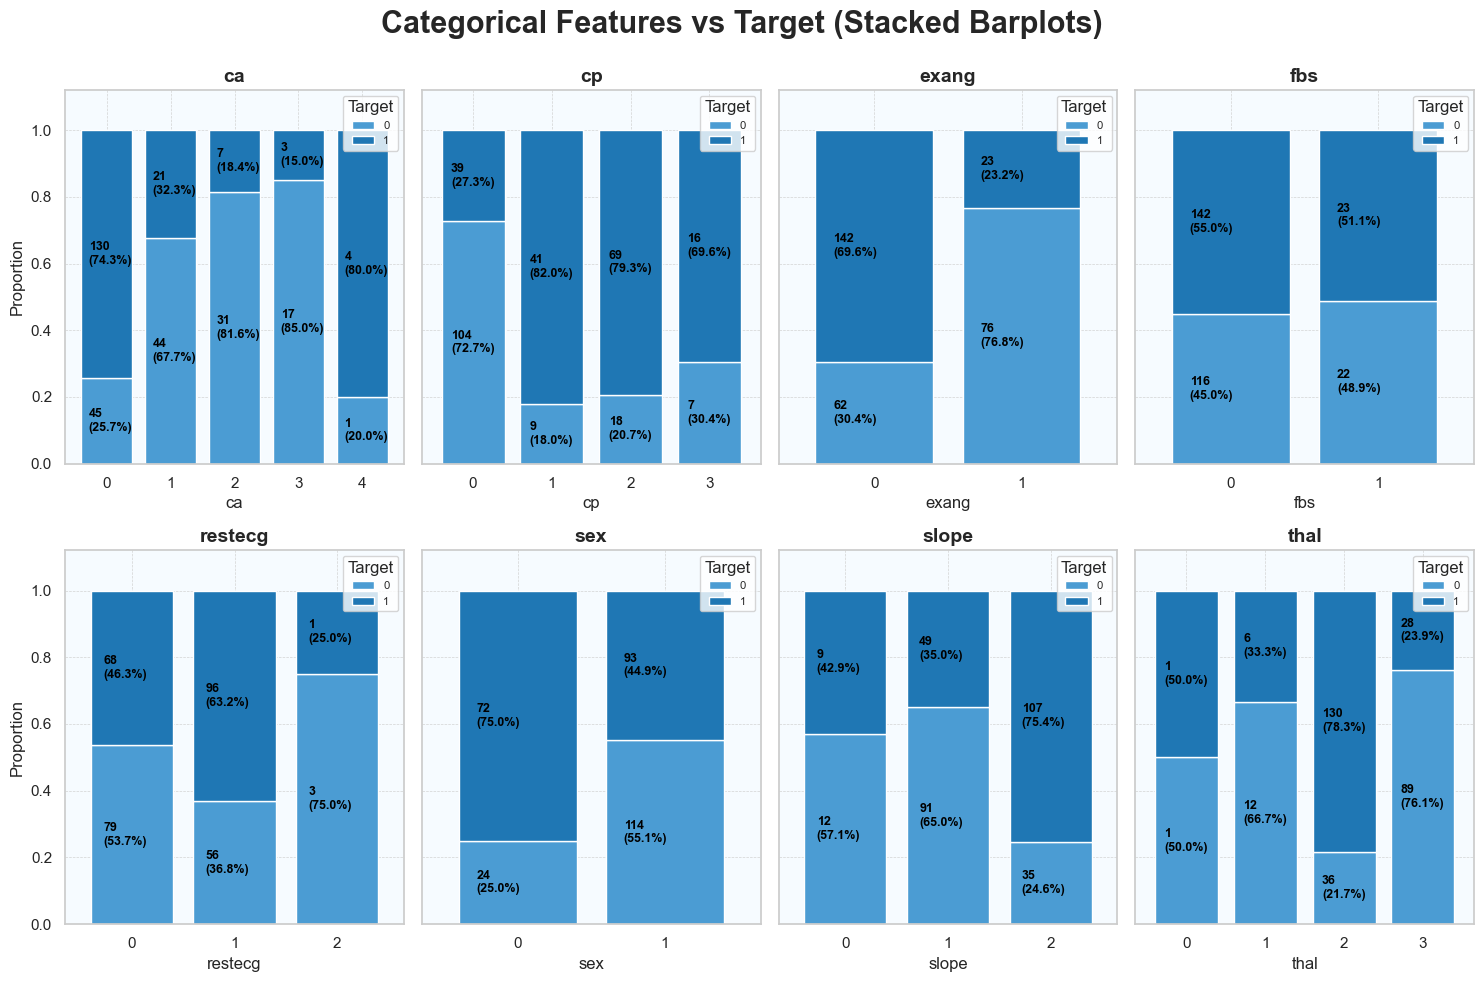

In [15]:
# Set white background with clean grid
sns.set_style("whitegrid")

# Define a custom blue colormap for the stacked bars
cmp = ListedColormap(['#4b9cd3', '#1f77b4'])  # Light to medium blues

# Set up the subplot grid
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
fig.patch.set_facecolor('white')

for i, col in enumerate(categorical_features):
    x, y = i // 4, i % 4

    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    # Plot stacked bar charts with blue colormap
    cross_tab_prop.plot(
        kind='bar', ax=ax[x, y], stacked=True, width=0.8,
        colormap=cmp, legend=False, ylabel='Proportion', sharey=True
    )

    # Add annotations
    for idx, val in enumerate(cross_tab.index):
        proportions = cross_tab_prop.loc[val]
        counts = cross_tab.loc[val]
        cumulative = proportions.cumsum()
        for proportion, count, y_loc in zip(proportions, counts, cumulative):
            label = f'{count}\n({proportion * 100:.1f}%)'
            y_pos = (y_loc - proportion) + (proportion / 2) - 0.03
            ax[x, y].text(idx - 0.28, y_pos, label, fontsize=9, fontweight="bold", color='black')

    ax[x, y].legend(title='Target', loc='upper right', fontsize=8)
    ax[x, y].set_ylim([0, 1.12])
    ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=0)
    ax[x, y].set_title(f"{col}", fontsize=14, fontweight='bold')
    ax[x, y].grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
    ax[x, y].set_facecolor('#f6fbff')  # Very light blue inside the axes

plt.suptitle('Categorical Features vs Target (Stacked Barplots)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [16]:
# Check for missing values in the dataset
df.isnull().sum().sum()

0

In [17]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [18]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64

<Figure size 1200x600 with 0 Axes>

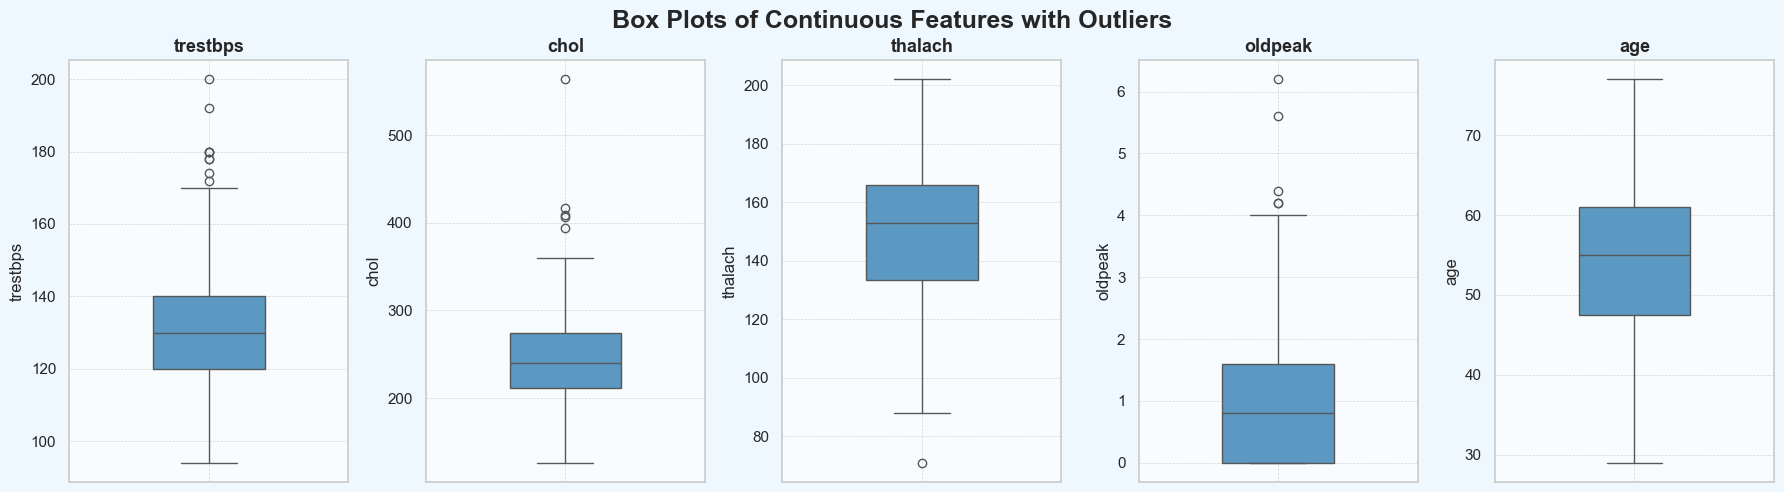

In [19]:
# Set Seaborn style and color palette
sns.set(style='whitegrid', palette='Blues')
plt.figure(figsize=(12, 6))
fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=False)
fig.patch.set_facecolor('#f0f8ff')  # Light blue background for figure

# List of features to plot (those with outliers)
outlier_features = ['trestbps', 'chol', 'thalach', 'oldpeak', 'age']

# Plot each feature
for i, col in enumerate(outlier_features):
    sns.boxplot(data=df, y=col, ax=axes[i], color='#4b9cd3', width=0.4)
    axes[i].set_title(col, fontsize=13, fontweight='bold')
    axes[i].set_facecolor('#f9fcff')  # Soft background per subplot
    axes[i].grid(True, linestyle='--', linewidth=0.5, color='lightgrey')

# Overall styling
fig.suptitle('Box Plots of Continuous Features with Outliers', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [20]:
# Perform one-hot encoding and explicitly cast encoded features to uint8
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True, dtype='uint8')

# Convert selected categorical features to int64 (instead of the default int32)
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype('int64')

# Verify the result
print(df_encoded.dtypes)


age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1           uint8
cp_2           uint8
cp_3           uint8
restecg_1      uint8
restecg_2      uint8
thal_1         uint8
thal_2         uint8
thal_3         uint8
dtype: object


In [21]:
# Displaying the resulting DataFrame after one-hot encoding
df_encoded.head()

age  sex  trestbps  chol  fbs  thalach  exang  oldpeak  slope  ca  target  \
0   63    1       145   233    1      150      0      2.3      0   0       1   
1   37    1       130   250    0      187      0      3.5      0   0       1   
2   41    0       130   204    0      172      0      1.4      2   0       1   
3   56    1       120   236    0      178      0      0.8      2   0       1   
4   57    0       120   354    0      163      1      0.6      2   0       1   

   cp_1  cp_2  cp_3  restecg_1  restecg_2  thal_1  thal_2  thal_3  
0     0     0     1          0          0       1       0       0  
1     0     1     0          1          0       0       1       0  
2     1     0     0          0          0       0       1       0  
3     1     0     0          1          0       0       1       0  
4     0     0     0          1          0       0       1       0

In [22]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [23]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

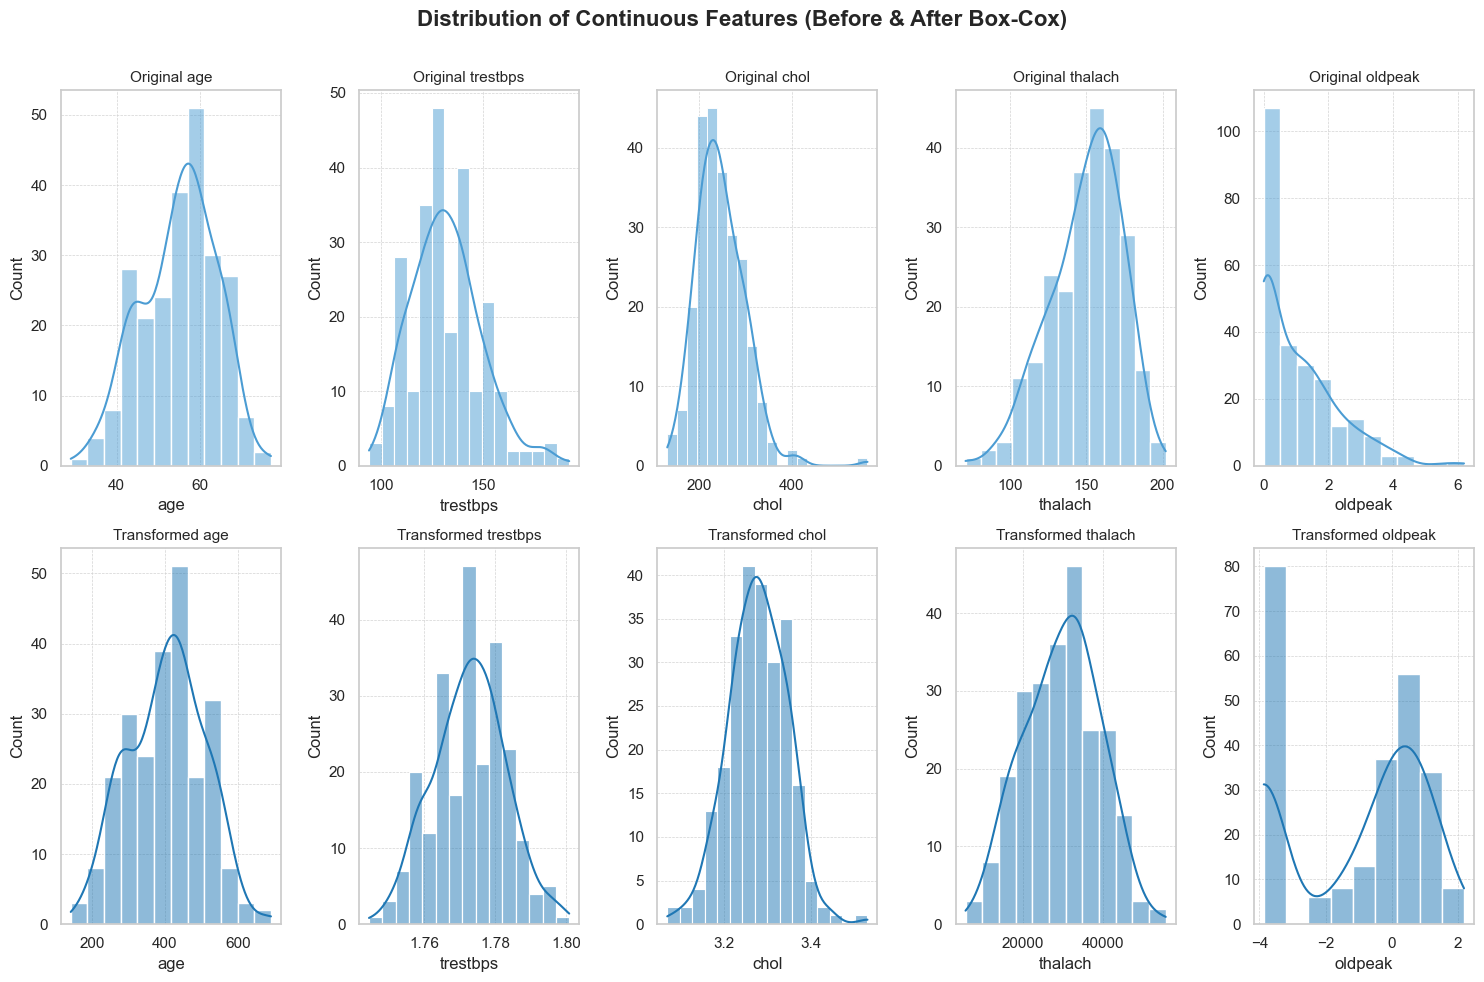

In [25]:
# Set white background and blue palette
sns.set_style("whitegrid")
blue_color_original = '#4b9cd3'
blue_color_transformed = '#1f77b4'
not_transformed_color = '#91c1e2'

# Prepare the subplot
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
fig.patch.set_facecolor('white')  # Canvas background

# Plot original distributions (top row)
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0, i], color=blue_color_original)
    ax[0, i].set_title(f'Original {col}', fontsize=11)
    ax[0, i].set_facecolor('white')
    ax[0, i].grid(True, linestyle='--', linewidth=0.5, color='lightgray')

# Apply Box-Cox transformation and plot (bottom row)
lambdas = {}

for i, col in enumerate(continuous_features):
    ax[1, i].set_facecolor('white')
    ax[1, i].grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])
        sns.histplot(X_train[col], kde=True, ax=ax[1, i], color=blue_color_transformed)
        ax[1, i].set_title(f'Transformed {col}', fontsize=11)
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1, i], color=not_transformed_color)
        ax[1, i].set_title(f'{col} (Not Transformed)', fontsize=11)

# Layout adjustments
plt.suptitle('Distribution of Continuous Features (Before & After Box-Cox)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


In [26]:
X_train.head()

age  sex  trestbps      chol  fbs       thalach  exang   oldpeak  \
74   269.050189    0  1.767600  3.239235    0  35696.593237      0 -1.385234   
153  538.237353    0  1.781771  3.324697    0  29779.969036      0 -3.869196   
64   436.708331    1  1.778577  3.236121    1  35696.593237      0 -3.869196   
296  499.220354    0  1.768938  3.213272    0  23294.611329      1 -3.869196   
287  424.590573    1  1.785733  3.267168    0  35220.604540      0 -3.869196   

     slope  ca  cp_1  cp_2  cp_3  restecg_1  restecg_2  thal_1  thal_2  thal_3  
74       1   0     0     1     0          1          0       0       1       0  
153      1   1     0     1     0          0          0       0       1       0  
64       2   0     0     1     0          0          0       0       1       0  
296      1   0     0     0     0          1          0       0       1       0  
287      2   1     1     0     0          0          0       0       1       0

In [27]:
X_test.head()

age  sex  trestbps      chol  fbs       thalach  exang   oldpeak  \
225  591.979724    1  1.781253  3.171120    0  19336.123139      1  1.047092   
152  512.101743    1  1.792789  3.260092    0  31093.389050      0 -0.485569   
228  448.955414    1  1.792789  3.335687    0  32892.978788      0 -1.385234   
201  461.330976    1  1.769595  3.301212    0  25227.912638      1  1.136364   
52   486.464245    1  1.772764  3.265768    0  27245.852233      0  0.622085   

     slope  ca  cp_1  cp_2  cp_3  restecg_1  restecg_2  thal_1  thal_2  thal_3  
225      0   0     0     0     0          1          0       0       0       1  
152      1   0     0     0     1          0          0       0       0       1  
228      1   0     0     0     1          0          0       0       0       1  
201      1   1     0     0     0          0          0       0       0       1  
52       1   3     0     1     0          1          0       0       0       1

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Dictionary to store model performance
model_scores = {}

# Define models and hyperparameter grids
models = {
    "Decision Tree": (DecisionTreeClassifier(), {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    }),
    
    "Random Forest": (RandomForestClassifier(), {
        "n_estimators": [50, 100],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5]
    }),

    "KNN": (Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]), {
        "knn__n_neighbors": [3, 5, 7],
        "knn__weights": ['uniform', 'distance']
    }),

    "SVM": (Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())
    ]), {
        "svc__C": [0.1, 1, 10],
        "svc__kernel": ['linear', 'rbf']
    }),

    "Logistic Regression": (Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=500))
    ]), {
        "logreg__C": [0.1, 1, 10],
        "logreg__penalty": ['l2']
    })
}

# Train and evaluate each model
for name, (model, params) in models.items():
    print(f"\n🔍 Tuning & Evaluating: {name}")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"✅ Best Params for {name}: {grid.best_params_}")
    print(classification_report(y_test, y_pred, target_names=["No Disease", "Disease"]))
    
    acc = accuracy_score(y_test, y_pred)
    model_scores[name] = acc

# 📊 Summary of Model Scores
print("\n📈 Model Accuracy Summary:")
for model, score in model_scores.items():
    print(f"{model}: {score:.4f}")



🔍 Tuning & Evaluating: Decision Tree
✅ Best Params for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
              precision    recall  f1-score   support

  No Disease       0.71      0.81      0.76        27
     Disease       0.83      0.74      0.78        34

    accuracy                           0.77        61
   macro avg       0.77      0.78      0.77        61
weighted avg       0.78      0.77      0.77        61


🔍 Tuning & Evaluating: Random Forest
✅ Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

  No Disease       0.82      0.85      0.84        27
     Disease       0.88      0.85      0.87        34

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


🔍 Tuning & Evaluating: KNN
✅ Best Params for KNN: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}

In [29]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Lists to collect results
evaluations = []

for name, (model, params) in models.items():
   
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    
    # Store in dictionary
    evaluations.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# Create results DataFrame
results_df = pd.DataFrame(evaluations).round(3).sort_values(by='F1-Score', ascending=False)
print("\n📊 Model Performance Summary:")
display(results_df)



📊 Model Performance Summary:


Model  Accuracy  Precision  Recall  F1-Score
3                  SVM     0.885      0.886   0.912     0.899
4  Logistic Regression     0.869      0.906   0.853     0.879
1        Random Forest     0.836      0.853   0.853     0.853
2                  KNN     0.836      0.875   0.824     0.848
0        Decision Tree     0.754      0.828   0.706     0.762

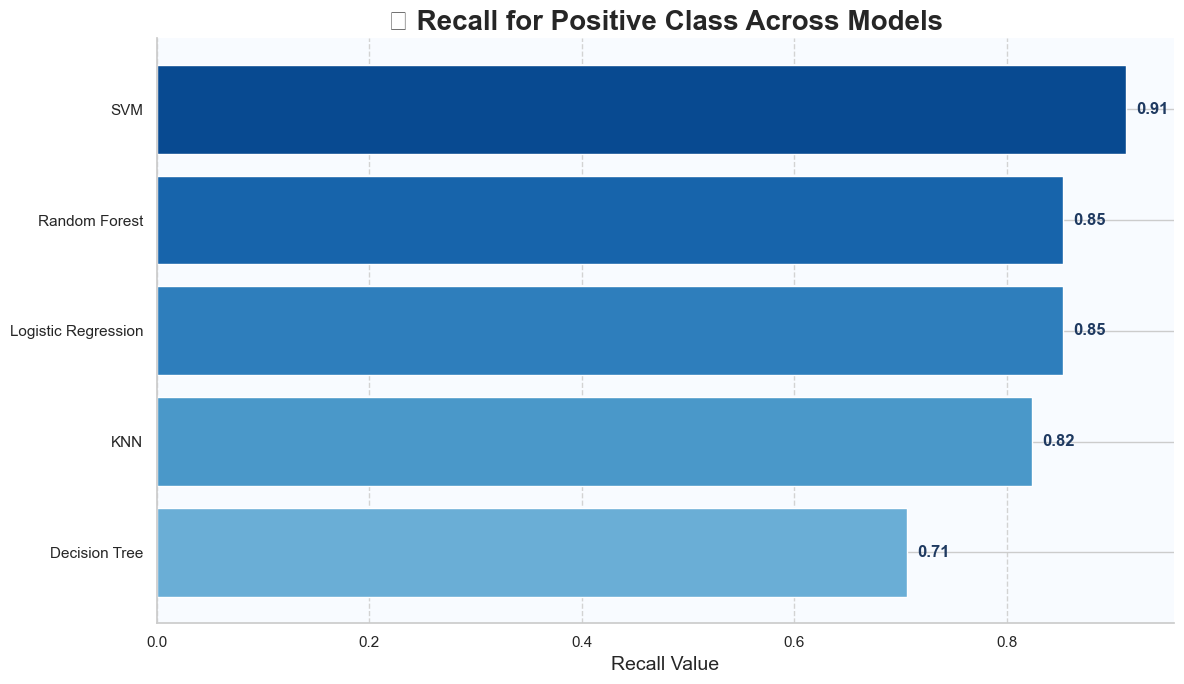

In [30]:
import matplotlib.pyplot as plt

# Sort by Recall score
results_df_sorted = results_df.sort_values(by='Recall', ascending=True).reset_index(drop=True)
recall_scores = results_df_sorted['Recall']
model_names = results_df_sorted['Model']

# Define blue gradient colors for bars
colors = plt.cm.Blues([0.5 + i / (2 * len(model_names)) for i in range(len(model_names))])

# Set up the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
fig.patch.set_facecolor('white')

# Plot with gradient blues
bars = ax.barh(model_names, recall_scores, color=colors)

# Add labels to bars
for bar, value in zip(bars, recall_scores):
    ax.text(value + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{value:.2f}", ha='left', va='center',
            fontsize=12, fontweight='bold', color='#1f3a61')

# Improve chart styling
ax.set_xlabel('Recall Value', fontsize=14)
ax.set_title('🔵 Recall for Positive Class Across Models', fontsize=20, fontweight='bold')
ax.grid(True, linestyle='--', axis='x', color='lightgrey')
ax.set_facecolor('#f8fbff')  # Subtle soft-blue panel background
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()
